# Spectral Partitioning of Bipartite Graphs

---

Typical example of bipartite graph is a graph obtained from a collection of documents presented as a __term $\times$ document__  matrix.

## Prerequisites

The reader should be familiar with k-means algorithm and spectral graph partitioning theory and algorithms.
 
## Competences 

The reader should be able to apply spectral partitioning of bipartite graphs to data clustering problems.

__Credits.__ The notebook is based on [I. Mirošević, Spectral Graph Partitioning and Application to Knowledge Extraction][Mir05].

[Mir05]: http://empty.link "I. Mirošević, 'Spectral Graph Partitioning and Application to Knowledge Extraction', M.Sc. Thesis, Iniversity of Zagreb, 2005 (in Croatian)." 

## Definitions

__Undirected bipartite graph__ $G$ is a triplet 
$G=(T,D,E)$, where $T=\{t_{1},\cdots ,t_{m}\}$ and 
$D=\{d_{1},...,d_{n}\}$ are two sets of vertices and
$E=\{(t_{i},d_{j}):t_{i}\in R,d_{j}\in D\}$, 
is a set of edges.

$G$ is __weighted__ if there is weight $\omega(e)$ associated with each edge $e\in E$.

For example, $D$ is a set of documents, 
$T$ is a set of terms (words) and  edge $e=(t_{i},d_{j})$ exists if
document $d_{j}$ contains term $t_{i}$. Weight $\omega(e)$ can be number of appearances 
of the term $t_i$ in the document $d_j$.

A __term-by-document-matrix__ is a matrix $A\in\mathbb{R}^{m\times n}$ with 
$A_{ij}=\omega((t_i,d_j))$.

## Facts

1. The weight matrix of $G$ is 
$W=\begin{bmatrix}0 & A \\ A^{T} & 0 \end{bmatrix}$.

2. The Laplacian matrix of $G$ is 
$$L=\begin{bmatrix} \Delta_{1} & -A \\ -A^{T} & \Delta_{2}\end{bmatrix},$$
where $\Delta_1$ and $\Delta_2$ are diagonal matrices with elements 
$\Delta_{1,ii}=\sum\limits_{j=1}^n A_{ij}$ for $i=1,\ldots,m$, and 
$\Delta_{1,jj}=\sum\limits_{i=1}^m A_{ij}$ for $j=1,\ldots,n$.

3. The normalized Laplacian matrix of $G$ is 
$$L_n=\begin{bmatrix}
I & -\Delta_{1}^{-\frac{1}{2}}A\Delta_{2}^{-\frac{1}{2}} \\
-\Delta_{2}^{-\frac{1}{2}}A^T\Delta_{1}^{-\frac{1}{2}} & I
\end{bmatrix} \equiv 
\begin{bmatrix} I & -A_n \\ -A_n^T & I \end{bmatrix}.
$$

4. Let $\lambda$ be an eigenvalue of $L_n$ with an eigenvector 
$w=\begin{bmatrix} u \\ v\end{bmatrix}$, where 
$u\in \mathbb{R}^{m}$ $v\in\mathbb{R}^{n}$.
Then $L_n w=\lambda w$ implies
$A_n v =(1-\lambda)u$ and $A_n^T u=(1-\lambda)v$. Vice versa, if $(u,\sigma,v)$ is a singular triplet of $A_n$, then $1-\sigma$ is an eigenvalue of $L_n$ with (non-unit) eigenvector $w=\begin{bmatrix} u \\ v\end{bmatrix}$. 

5. The second largest singular value of $A_n$ corresponds to the second smallest eigenvalue of $L_n$, and computing the former is numerically more stable. 

### Bipartitioning algorithm
1. For given $A$ compute $A_{n}$.
2. Compute singular vectors of $A_{n}$, $u^{[2]}$ and $v^{[2]}$, which correspond to 
the second largest singular value, $\sigma_2(A_n)$.
3. Assign the partitions $T=\{T_1,T_2\}$ and $D=\{D_1,D_2\}$ according to the signs of 
$u^{[2]}$ and $v^{[2]}$. The pair $(T,D)$ is now partitioned as 
$\{(T_1,D_1),(T_2,D_2)\}$.


### Recursive bipartitioning algorithm
1. Compute the bipartition $\pi=\{(T_1,D_1),(T_2,D_2)\}$ of 
$(T,D)$. Set the counter $c=2$.
2. While $c<k$ repeat
   1. compute bipartitions of each of the subpartitions of $(T,D)$,
   2. among all $(c+1)$-subpartitions, choose the one with the smallest $pcut(\pi_{c+1})$ or $ncut(\pi_{c+1})$, respectively.
3. Set $c=c+1$
3. Stop

### Multipartitioning algorithm
1. For given $A$ compute $A_{n}$.
2. Compute $k$ left and right singular vectors, $u^{[1]},\ldots,u^{[k]}$ and 
$v^{[1]},\ldots,v^{[k]}$, which correspond to $k$ largest singular values 
$\sigma_1\geq \cdots \geq \sigma_k$ of $A_n$.
3. Partition the rows of matrices 
$\Delta_{1}^{-\frac{1}{2}}\begin{bmatrix} u^{[1]} & \ldots & u^{[k]}\end{bmatrix}$
and 
$\Delta_{2}^{-\frac{1}{2}}\begin{bmatrix} v^{[1]} & \ldots & v^{[k]}\end{bmatrix}$
with the k-means algorithm.

### Small term-by- document matrix

In [1]:
# Packages
using LightGraphs
using GraphPlot
using Clustering
using SparseArrays
using LinearAlgebra

In [2]:
using Plots

In [3]:
import Plots.spy
spy(A)=heatmap(A,yflip=true,color=:RdBu,aspectratio=1,clim=(-1,1.0)) 

spy (generic function with 2 methods)

In [4]:
# Functions

function WeightMatrix(src::Array,dst::Array,weights::Array)
    n=nv(G)
    sparse([src;dst],[dst;src],[weights;weights],n,n)
end

Laplacian(W::AbstractMatrix)=spdiagm(0=>vec(sum(W,dims=2)))-W

function NormalizedLaplacian(L::AbstractMatrix)
    D=1.0./sqrt.(diag(L))
    n=length(D)
    [L[i,j]*(D[i]*D[j]) for i=1:n, j=1:n]
end

NormalizedLaplacian (generic function with 1 method)

In [5]:
# Sources, targets, and weights
n=7
dn=[6,6,7,6,7,7]
tn=[1,2,2,3,4,5]
wn=[3,1,3,2,2,3]
[dn tn wn]

6×3 Array{Int64,2}:
 6  1  3
 6  2  1
 7  2  3
 6  3  2
 7  4  2
 7  5  3

In [6]:
mynames=["Term 1";"Term 2";"Term 3";"Term 4";"Term 5";"Doc 1";"Doc 2"]

7-element Array{String,1}:
 "Term 1"
 "Term 2"
 "Term 3"
 "Term 4"
 "Term 5"
 "Doc 1"
 "Doc 2"

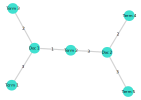

In [7]:
G=Graph(n)
for i=1:length(dn)
    add_edge!(G,tn[i],dn[i])
end
gplot(G, nodelabel=mynames, edgelabel=wn)

In [8]:
W=WeightMatrix(tn,dn,wn)

7×7 SparseMatrixCSC{Int64,Int64} with 12 stored entries:
  [6, 1]  =  3
  [6, 2]  =  1
  [7, 2]  =  3
  [6, 3]  =  2
  [7, 4]  =  2
  [7, 5]  =  3
  [1, 6]  =  3
  [2, 6]  =  1
  [3, 6]  =  2
  [2, 7]  =  3
  [4, 7]  =  2
  [5, 7]  =  3

In [9]:
Matrix(W)

7×7 Array{Int64,2}:
 0  0  0  0  0  3  0
 0  0  0  0  0  1  3
 0  0  0  0  0  2  0
 0  0  0  0  0  0  2
 0  0  0  0  0  0  3
 3  1  2  0  0  0  0
 0  3  0  2  3  0  0

In [10]:
L=Laplacian(W)
Matrix(L)

7×7 Array{Int64,2}:
  3   0   0   0   0  -3   0
  0   4   0   0   0  -1  -3
  0   0   2   0   0  -2   0
  0   0   0   2   0   0  -2
  0   0   0   0   3   0  -3
 -3  -1  -2   0   0   6   0
  0  -3   0  -2  -3   0   8

In [11]:
Lₙ=NormalizedLaplacian(L)

7×7 Array{Float64,2}:
  1.0        0.0        0.0       0.0   0.0       -0.707107   0.0
  0.0        1.0        0.0       0.0   0.0       -0.204124  -0.53033
  0.0        0.0        1.0       0.0   0.0       -0.57735    0.0
  0.0        0.0        0.0       1.0   0.0        0.0       -0.5
  0.0        0.0        0.0       0.0   1.0        0.0       -0.612372
 -0.707107  -0.204124  -0.57735   0.0   0.0        1.0        0.0
  0.0       -0.53033    0.0      -0.5  -0.612372   0.0        1.0

In [12]:
A=W[1:5,6:7]
Δ₁=sqrt.(sum(A,dims=2))
Δ₂=sqrt.(sum(A,dims=1))
Aₙ=[A[i,j]/(Δ₁[i]*Δ₂[j]) for i=1:size(A,1), j=1:size(A,2)]

5×2 Array{Float64,2}:
 0.707107  0.0
 0.204124  0.53033
 0.57735   0.0
 0.0       0.5
 0.0       0.612372

In [13]:
# The partitioning - explain the results!
U,σ,V=svd(Aₙ)

SVD{Float64,Float64,Array{Float64,2}}
U factor:
5×2 Array{Float64,2}:
 -0.46291    0.604743
 -0.534522  -0.218218
 -0.377964   0.493771
 -0.377964  -0.370328
 -0.46291   -0.453557
singular values:
2-element Array{Float64,1}:
 0.9999999999999999
 0.8838834764831844
Vt factor:
2×2 Array{Float64,2}:
 -0.654654  -0.755929
  0.755929  -0.654654

In [14]:
U[:,2]

5-element Array{Float64,1}:
  0.6047431568147631
 -0.21821789023599317
  0.4937707198786937
 -0.37032803990902124
 -0.45355736761107346

In [15]:
V[:,2]

2-element Array{Float64,1}:
  0.7559289460184536
 -0.6546536707079783

### Sets of points

In [16]:
# Define sizes
using Random
m=[200,100,100]
n=[100,200,100]
density=[0.5,0.7,0.4]
A=Array{Any}(undef,3)
Random.seed!(421)
for i=1:3
    # Generate sparse random matrix
    A[i]=sprand(m[i],n[i],density[i])
end
B=blockdiag(A[1],A[2],A[3])

400×400 SparseMatrixCSC{Float64,Int64} with 27991 stored entries:
  [1  ,   1]  =  0.934799
  [5  ,   1]  =  0.944809
  [7  ,   1]  =  0.434606
  [10 ,   1]  =  0.649754
  [14 ,   1]  =  0.779423
  [21 ,   1]  =  0.454876
  [24 ,   1]  =  0.512495
  [26 ,   1]  =  0.835728
  [28 ,   1]  =  0.115423
  [30 ,   1]  =  0.00835897
  [32 ,   1]  =  0.171255
  [33 ,   1]  =  0.503929
  ⋮
  [368, 400]  =  0.0100192
  [369, 400]  =  0.242538
  [370, 400]  =  0.717698
  [373, 400]  =  0.619461
  [375, 400]  =  0.870078
  [377, 400]  =  0.799436
  [380, 400]  =  0.0400151
  [383, 400]  =  0.609164
  [387, 400]  =  0.541328
  [388, 400]  =  0.873791
  [393, 400]  =  0.551811
  [396, 400]  =  0.796182
  [397, 400]  =  0.145492

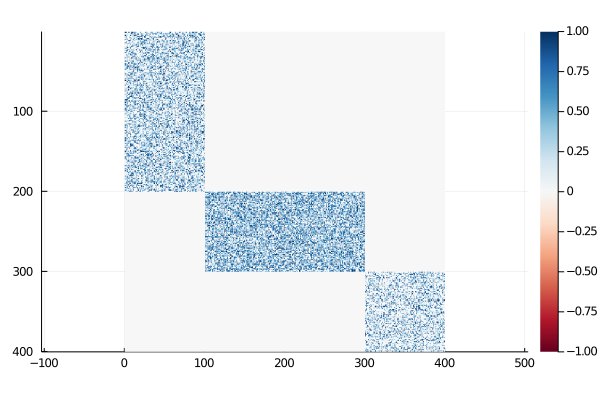

In [17]:
spy(Matrix(B))

In [18]:
# The structure of singular vectors reflects the blocks
using Arpack
S,rest=svds(B,nsv=3)

(SVD{Float64,Float64,Array{Float64,2}}([0.0 -0.07244475487076579 -7.806255641895632e-18; -2.0532834118754687e-17 -0.061615823495919875 -1.3877787807814457e-17; … ; -1.1300289827758452e-17 1.1919083438561808e-17 -0.09436486859935228; -1.0291902263738496e-17 1.2028913314286445e-17 -0.0901327410237115], [50.059161470849624, 35.92434913384256, 20.19597171502719], [-5.219156261682943e-17 -3.1092133510025864e-17 … -3.739860908936447e-17 -1.5982416470044688e-17; -0.10043631985202875 -0.09278761018766787 … 1.80747534449352e-17 1.4210149110146852e-17; 3.693078524689083e-17 6.415895729620492e-18 … -0.09497457389680324 -0.09716151681810949]), 3, 1, 20, [0.5020609915719024, -0.777508438360856, -0.8706181892609673, 0.418110718433147, -1.5398276865215073, 1.1383927232401694, 1.2659124474471442, -0.858928964235698, 1.5068251673479456, 0.722822439654613  …  0.10967095309681138, -0.1580243177673402, 1.1768556679973061, 1.4628932623292497, -0.1610287742437778, -0.8132360014061851, 0.8700513422259947, -1

In [19]:
# S is a structure
S.S

3-element Array{Float64,1}:
 50.059161470849624
 35.92434913384256
 20.19597171502719

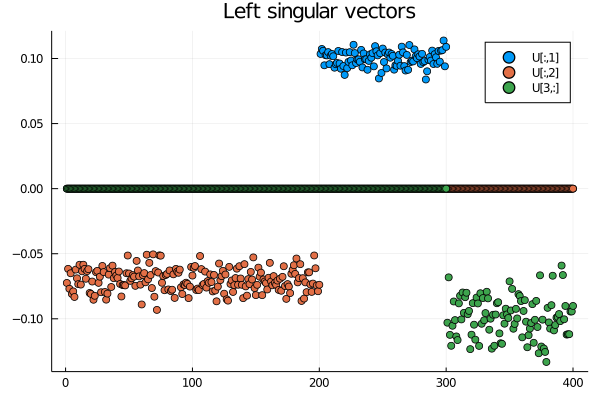

In [20]:
# Plot the first three left singular vectors
k=size(B,1)
x=collect(1:k)
scatter(x,S.U[:,1],title="Left singular vectors",label="U[:,1]")
scatter!(x,S.U[:,2],label="U[:,2]")
scatter!(x,S.U[:,3],label="U[3,:]")

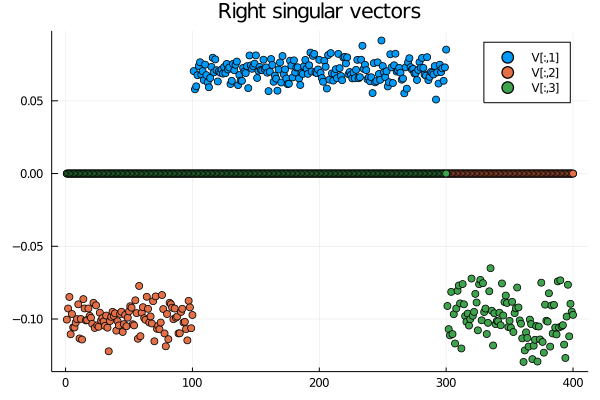

In [21]:
# Plot the first three right singular vectors
scatter(x,S.Vt[1,:],title="Right singular vectors",label="V[:,1]")
scatter!(x,S.Vt[2,:],label="V[:,2]")
scatter!(x,S.Vt[3,:],label="V[:,3]")

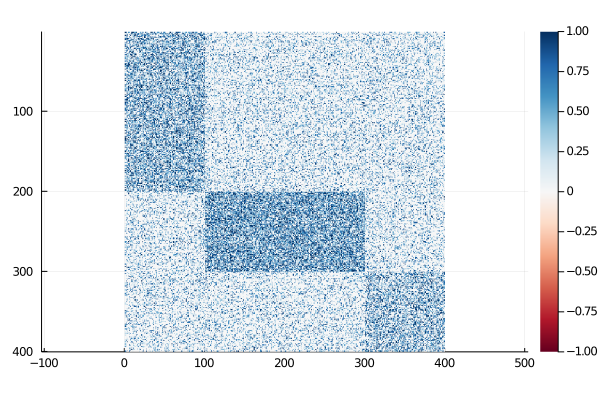

In [22]:
# Add random noise
noise=sprand(k,k,0.3)
C=B+noise
spy(Matrix(C))

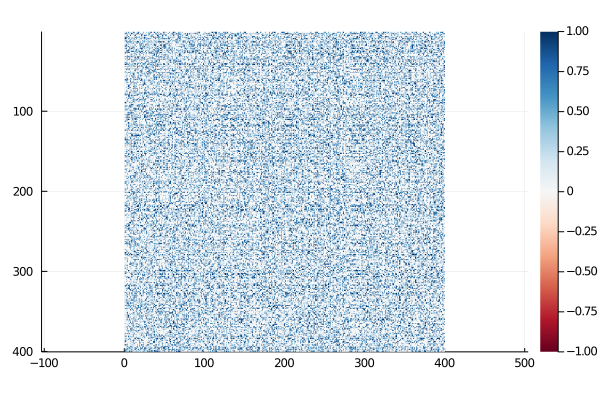

In [23]:
# Apply random permutation to rows and columns of C
using Random
D=C[randperm(k),randperm(k)]
spy(Matrix(D))

__Question.__ Given D, can we recover C?

__Answer.__ Yes (with spectral partitioning)!

In [24]:
S,rest=svds(D,nsv=3)

(SVD{Float64,Float64,Array{Float64,2}}([0.044386548595239717 0.03752590812177574 0.013590469603589402; 0.06558175508823162 -0.06591469286135232 0.016936419068422463; … ; 0.04254042678834388 0.042256728301967965 0.010657861523490105; 0.06223372375741314 -0.06184210340607412 0.020291850213298764], [99.46027831415488, 42.97817730671637, 25.496547277259722], [0.04985209729319672 0.05344837060558636 … 0.05074832215121943 0.03532946746040171; -0.04231256309780221 -0.03483808349068926 … -0.03599975957400301 0.029514316233302043; 0.007614992868537066 0.013412922795723602 … 0.02714501255806286 -0.08521342173308798]), 3, 1, 20, [-3.8984039918167417, -2.8097472012108553, -0.8309581092651191, -1.8172994897957042, -1.5972587817954544, 0.9809900601023849, -4.0681924076991045, 0.04434770799320463, 0.5145581083661516, 0.8381997471197452  …  1.4081416489304908, -2.5323182896761813, -5.023538819853879, 1.0593190194440185, -3.5517109511230682, -0.738213759303788, -1.5567541576431443, 0.08915260132576731,

In [25]:
# K-means on rows of U 
outU=kmeans(Matrix(transpose(S.U)),3)

KmeansResult{Array{Float64,2},Float64,Int64}([0.043453468908550646 0.03778154432493852 0.06895656757612129; 0.0485515132608859 0.014462963441740964 -0.06923489688029416; 0.024570710957248637 -0.08788590332355907 0.016967233700937657], [1, 3, 3, 1, 2, 1, 3, 1, 3, 1  …  1, 1, 1, 2, 3, 3, 1, 3, 1, 3], [0.0002430003065698929, 2.241406359739309e-5, 2.8913712093597832e-5, 0.00010030792536656029, 7.027108401858745e-5, 0.00041244846150011, 4.252856615795386e-6, 0.0004716990789874684, 7.853329818040267e-5, 0.00027296364277830127  …  4.873458640600355e-5, 0.00021915779185500452, 3.30239751891951e-5, 9.617915242258676e-5, 3.2380602372365785e-5, 5.043981651463997e-5, 0.0008656561761883879, 2.8567492815431e-5, 0.0002340253429587262, 0.00011090309931748032], [200, 100, 100], [200, 100, 100], 0.11047329424341787, 2, true)

In [26]:
# K-means on Vt
outV=kmeans(S.Vt,3)

KmeansResult{Array{Float64,2},Float64,Int64}([0.05175885613613821 0.0542388239211266 0.03732232077322476; 0.07409603287175123 -0.043175232732814185 0.02307550967349127; 0.03972339788780048 0.010792685451516577 -0.08649568101012778], [2, 2, 2, 3, 2, 2, 3, 1, 2, 3  …  2, 2, 2, 1, 3, 1, 2, 1, 2, 3], [3.008529955928277e-5, 7.69985176694906e-5, 9.274383246234141e-5, 0.00010116266427773538, 6.422600303909384e-5, 6.0496719134493435e-5, 0.0003679873278594169, 9.343458530736148e-5, 0.00012126840921348157, 3.423415063957824e-5  …  4.385453144629958e-5, 8.785081345880422e-6, 6.221270277217798e-5, 0.0002695424214223287, 7.753882963951186e-5, 0.0002184640923663314, 0.00013575122649891677, 0.00026939236950510384, 0.000331069619458035, 4.707388309464766e-5], [100, 200, 100], [100, 200, 100], 0.1001047174127712, 2, true)

In [27]:
sortperm(outV.assignments)

400-element Array{Int64,1}:
   8
  11
  12
  14
  18
  21
  27
  37
  40
  43
  57
  60
  62
   ⋮
 338
 342
 345
 349
 350
 372
 374
 378
 380
 389
 395
 400

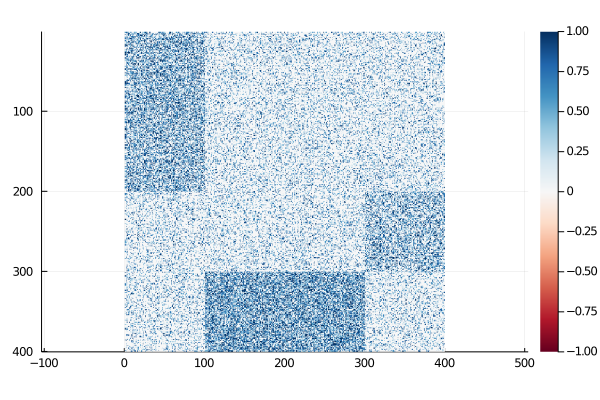

In [28]:
E=D[sortperm(outU.assignments),sortperm(outV.assignments)]
spy(Matrix(E))